In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf

def model_design(row, col, num_classes):
    tf.keras.initializers.GlorotNormal(seed=241)
    input_layer = tf.keras.Input(shape=(row, col, 1))
    layer = tf.keras.layers.Flatten()(input_layer)  
    layer = tf.keras.layers.GaussianNoise(0.1)(layer)
    layer = tf.keras.layers.Reshape((row, col))(layer) 
    layer1 = tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu")(layer)
    layer1 = tf.keras.layers.BatchNormalization()(layer1)
    layer1 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation="relu")(layer1)
    layer1 = tf.keras.layers.BatchNormalization()(layer1)
    layer1 = tf.keras.layers.Dropout(0.1)(layer1)
    layer2 = tf.keras.layers.Conv1D(filters=48, kernel_size=7, activation="relu")(layer1)
    layer2 = tf.keras.layers.BatchNormalization()(layer2)
    layer2 = tf.keras.layers.Conv1D(filters=64, kernel_size=9, activation="relu")(layer2)
    layer2 = tf.keras.layers.BatchNormalization()(layer2)
    layer2 = tf.keras.layers.Dropout(0.1)(layer2)  
    layer2 = tf.keras.layers.LSTM(32, return_sequences=True)(layer2)
    layer3 = tf.keras.layers.Conv1D(filters=96, kernel_size=11, activation="relu")(layer2)
    layer3 = tf.keras.layers.BatchNormalization()(layer3)
    layer3 = tf.keras.layers.Conv1D(filters=128, kernel_size=13, activation="relu")(layer3)
    layer3 = tf.keras.layers.BatchNormalization()(layer3)
    layer3 = tf.keras.layers.Dropout(0.1)(layer3)  
    global_avg = tf.keras.layers.GlobalAveragePooling1D()(layer3)
    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(global_avg)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

model = model_design(4500, 1, 4)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4500, 1, 1)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 4500)              0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 4500)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4500, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4498, 16)          64        
_________________________________________________________________
batch_normalization (BatchNo (None, 4498, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4494, 32)          2592  

In [6]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -tf.reduce_sum(alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)) - \
               tf.reduce_sum((1 - alpha) * tf.pow(pt, gamma) * tf.math.log(1 - pt))
        return loss
    return focal_loss_fixed


In [7]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [8]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 56s 412ms/step - loss: 1.4352 - accuracy: 0.5967 - val_loss: 1.4118 - val_accuracy: 0.5755
Epoch 2/80
110/110 [==============================] - 42s 386ms/step - loss: 1.0929 - accuracy: 0.6548 - val_loss: 1.2761 - val_accuracy: 0.6000
Epoch 3/80
110/110 [==============================] - 43s 391ms/step - loss: 1.0183 - accuracy: 0.6756 - val_loss: 1.2561 - val_accuracy: 0.5956
Epoch 4/80
110/110 [==============================] - 42s 385ms/step - loss: 0.9931 - accuracy: 0.6803 - val_loss: 1.0286 - val_accuracy: 0.6654
Epoch 5/80
110/110 [==============================] - 41s 377ms/step - loss: 0.9633 - accuracy: 0.6867 - val_loss: 0.9650 - val_accuracy: 0.6965
Epoch 6/80
110/110 [==============================] - 43s 389ms/step - loss: 0.9475 - accuracy: 0.6923 - val_loss: 1.0355 - val_accuracy: 0.6730
Epoch 7/80
110/110 [==============================] - 42s 383ms/step - loss: 0.9199 - accuracy: 0.7031 - val_loss: 1.0048 - val_ac

In [9]:
evaluate_model(model,X_test,y_test)

Precision: 0.7199344360335522
Recall: 0.619352065851733
F1 Score: 0.653896375601589
Accuracy: 0.7638777152051488
Class 1 - Precision: 0.7162790697674418, Recall: 0.6784140969162996, F1 Score: 0.6968325791855203
Class 2 - Precision: 0.7848244620611552, Recall: 0.9233844103930713, F1 Score: 0.8484848484848484
Class 3 - Precision: 0.7119675456389453, Recall: 0.47560975609756095, F1 Score: 0.5702680747359871
Class 4 - Precision: 0.6666666666666666, Recall: 0.4, F1 Score: 0.5
Class 1 Accuracy: 0.9460981496379727
Class 2 Accuracy: 0.8008849557522124
Class 3 Accuracy: 0.7872083668543846
Class 4 Accuracy: 0.9935639581657281


In [10]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

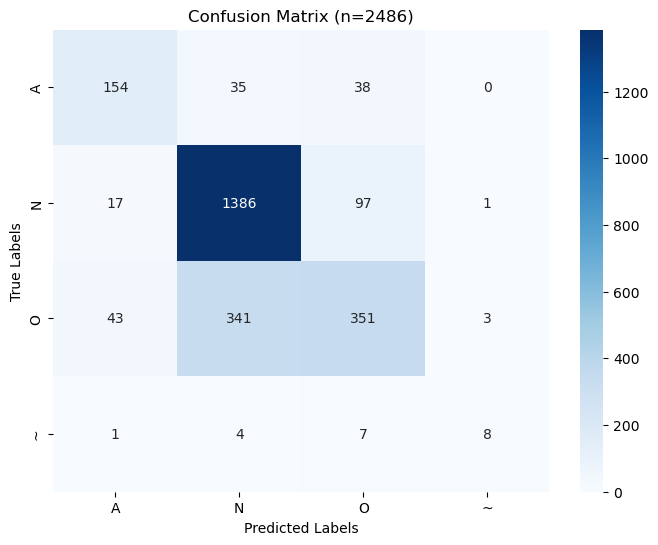

In [11]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])